(mmm_lift_test)=

# Lift Test Calibration

## Introduction

You may have heard of the phrase "all models are wrong; some models are useful." This is true in many areas, and it's likely that after the first attempt, you haven't yet created a model that can accurately determine your true attribution. Even if you have, how can you be sure? We create models to understand the attribution of our marketing channels, but it appears that even then, we can't always rely on what the models tell us.

In order to ensure that our models are decomposing correctly, we can use various testing methods to gather real-world data and compare it with our models. This will help us to identify any discrepancies and improve the decomposition accuracy of our models. 

Today, we will explore a new way to integrate experiments into **pymc-marketing**. This will bring us closer to accurate representations of real-world values and improve the estimates generated by our models.

## Requirements

Today, we won't be discussing how to conduct various tests, but instead, we will focus on their utilization. If you wish to acquire knowledge on how to generate results that are compatible with your MMM models, you can check out [CausalPy](https://causalpy.readthedocs.io/en/latest/) for conducting experiments.

## Goal

After reading this notebook, you will have gained the necessary expertise to incorporate the results (detected uplift from your experiments) into our regressive model.

This notebook will display using the `add_lift_test_measurements` method of `MMM` and its workflow:

1. Build model: `mmm.build_model(X, y)`
2. Add lift measurements: `mmm.add_lift_test_measurements(df_lift_test)`
2. Sample posterior: `mmm.fit(X, y)`

This is a case study of two correlated channels to see how lift tests help distinguish the channel effects.

In [1]:
import warnings
from functools import partial

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import logistic_saturation

In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%config InlineBackend.figure_format = 'retina'

## Generate Correlated Spends and Model Target

Spend data for two channels with completely correlated spends


In [3]:
seed = sum(map(ord, "Lift tests help distinguish channel effects"))
rng = np.random.default_rng(seed)

In [4]:
n_dates = 52
dates = pd.date_range(start="2024-01-01", periods=n_dates, freq="W-MON")

spend_rv = pm.Uniform.dist(lower=0, upper=1, size=n_dates)

spend = pm.draw(spend_rv, random_seed=rng)

spend /= spend.max()

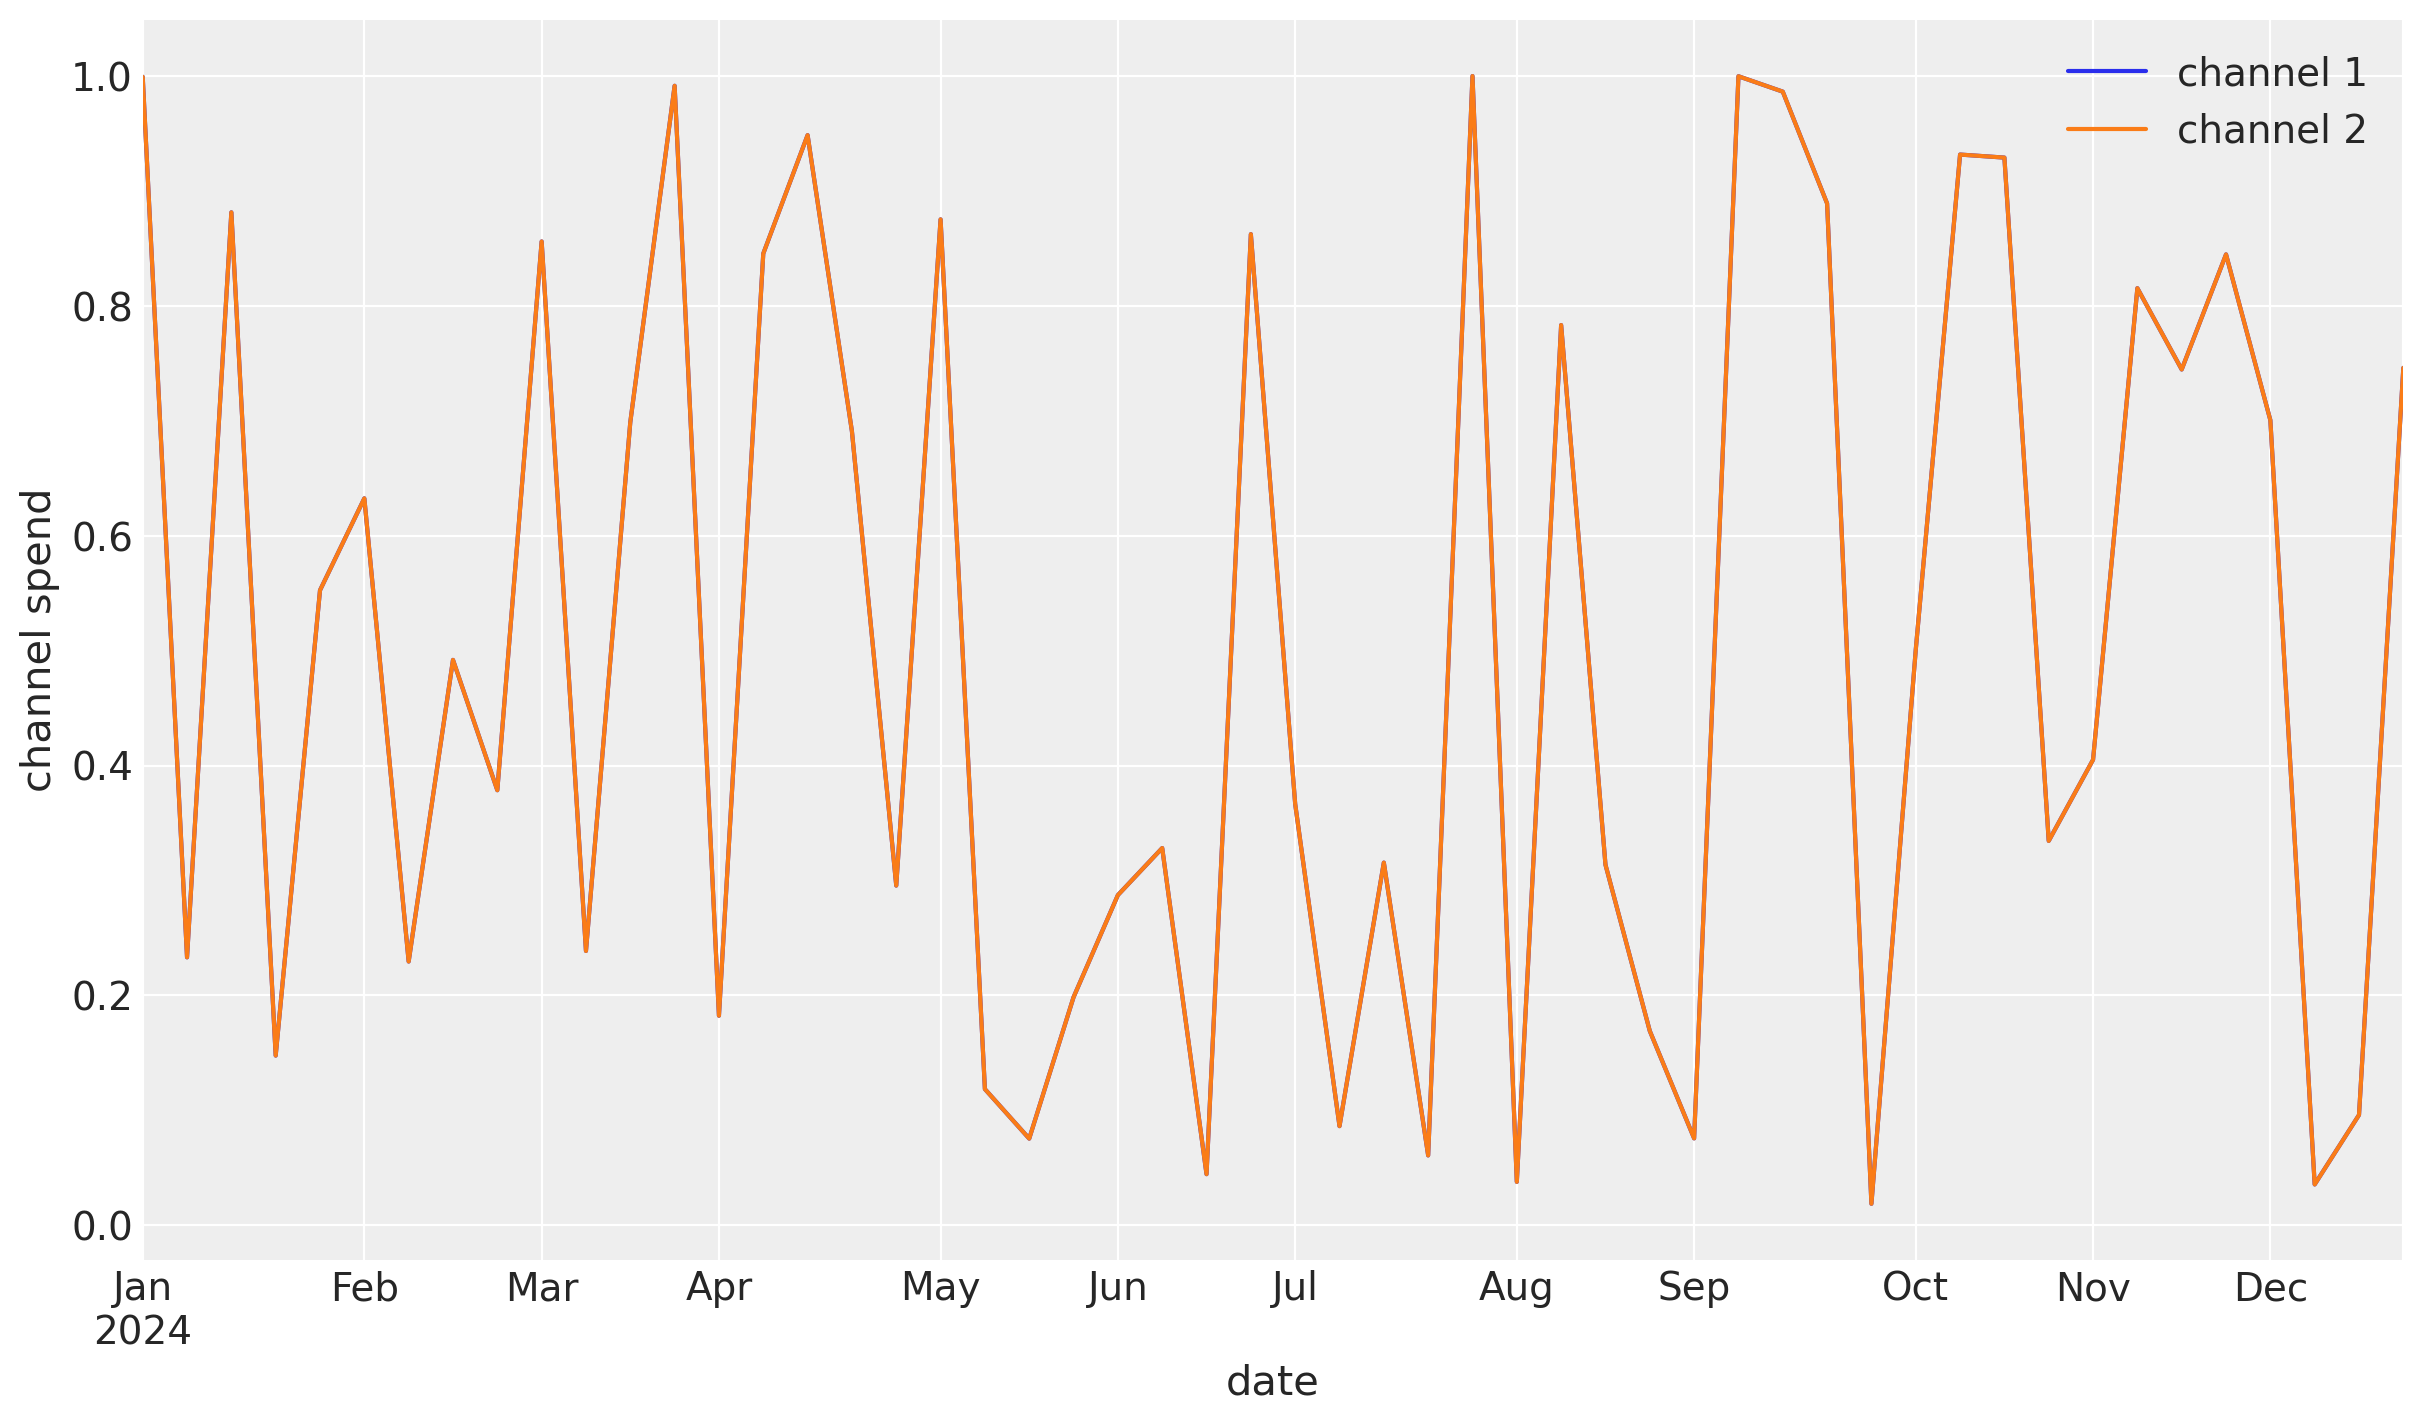

In [5]:
df = pd.DataFrame(
    {
        "date": dates,
        "channel 1": spend,
        "channel 2": spend,
    }
)

ax = df.set_index("date").plot(ylabel="channel spend");

Perfectly correlated data

In [6]:
df.filter(regex="channel").corr()

,channel 1,channel 2
channel 1,1.0,1.0
channel 2,1.0,1.0


We use the `MMM` class to specify our model just as usual. 

In [7]:
mmm = MMM(
    date_column="date",
    channel_columns=["channel 1", "channel 2"],
    adstock=GeometricAdstock(l_max=6),
    saturation=LogisticSaturation(),
)

For this constructed example, we will set parameter of the model with the `pm.do` operator and take a random sample of the target variable. The fixed parameters are below which we will try to recover.

At this point, a model has not been fit. However, we have created our data set to fit our model on.

Note: The max value of each spend column was set to 1 in order to account for model prepreprocessing

In [8]:
true_lam_c1 = 10
true_beta_c1 = 0.55

true_lam_c2 = 1.5
true_beta_c2 = 1.0

true_params = {
    "adstock_alpha": [0.5, 0.5],
    "saturation_lam": [true_lam_c1, true_lam_c2],
    "saturation_beta": [true_beta_c1, true_beta_c2],
    "intercept": 0.5,
    "y_sigma": 0.25,
}

In [9]:
mmm.build_model(df.reset_index(), y=np.ones(n_dates))
fixed_model = pm.do(mmm.model, true_params)
df["y"] = pm.draw(fixed_model["y"], random_seed=rng)
del mmm.model

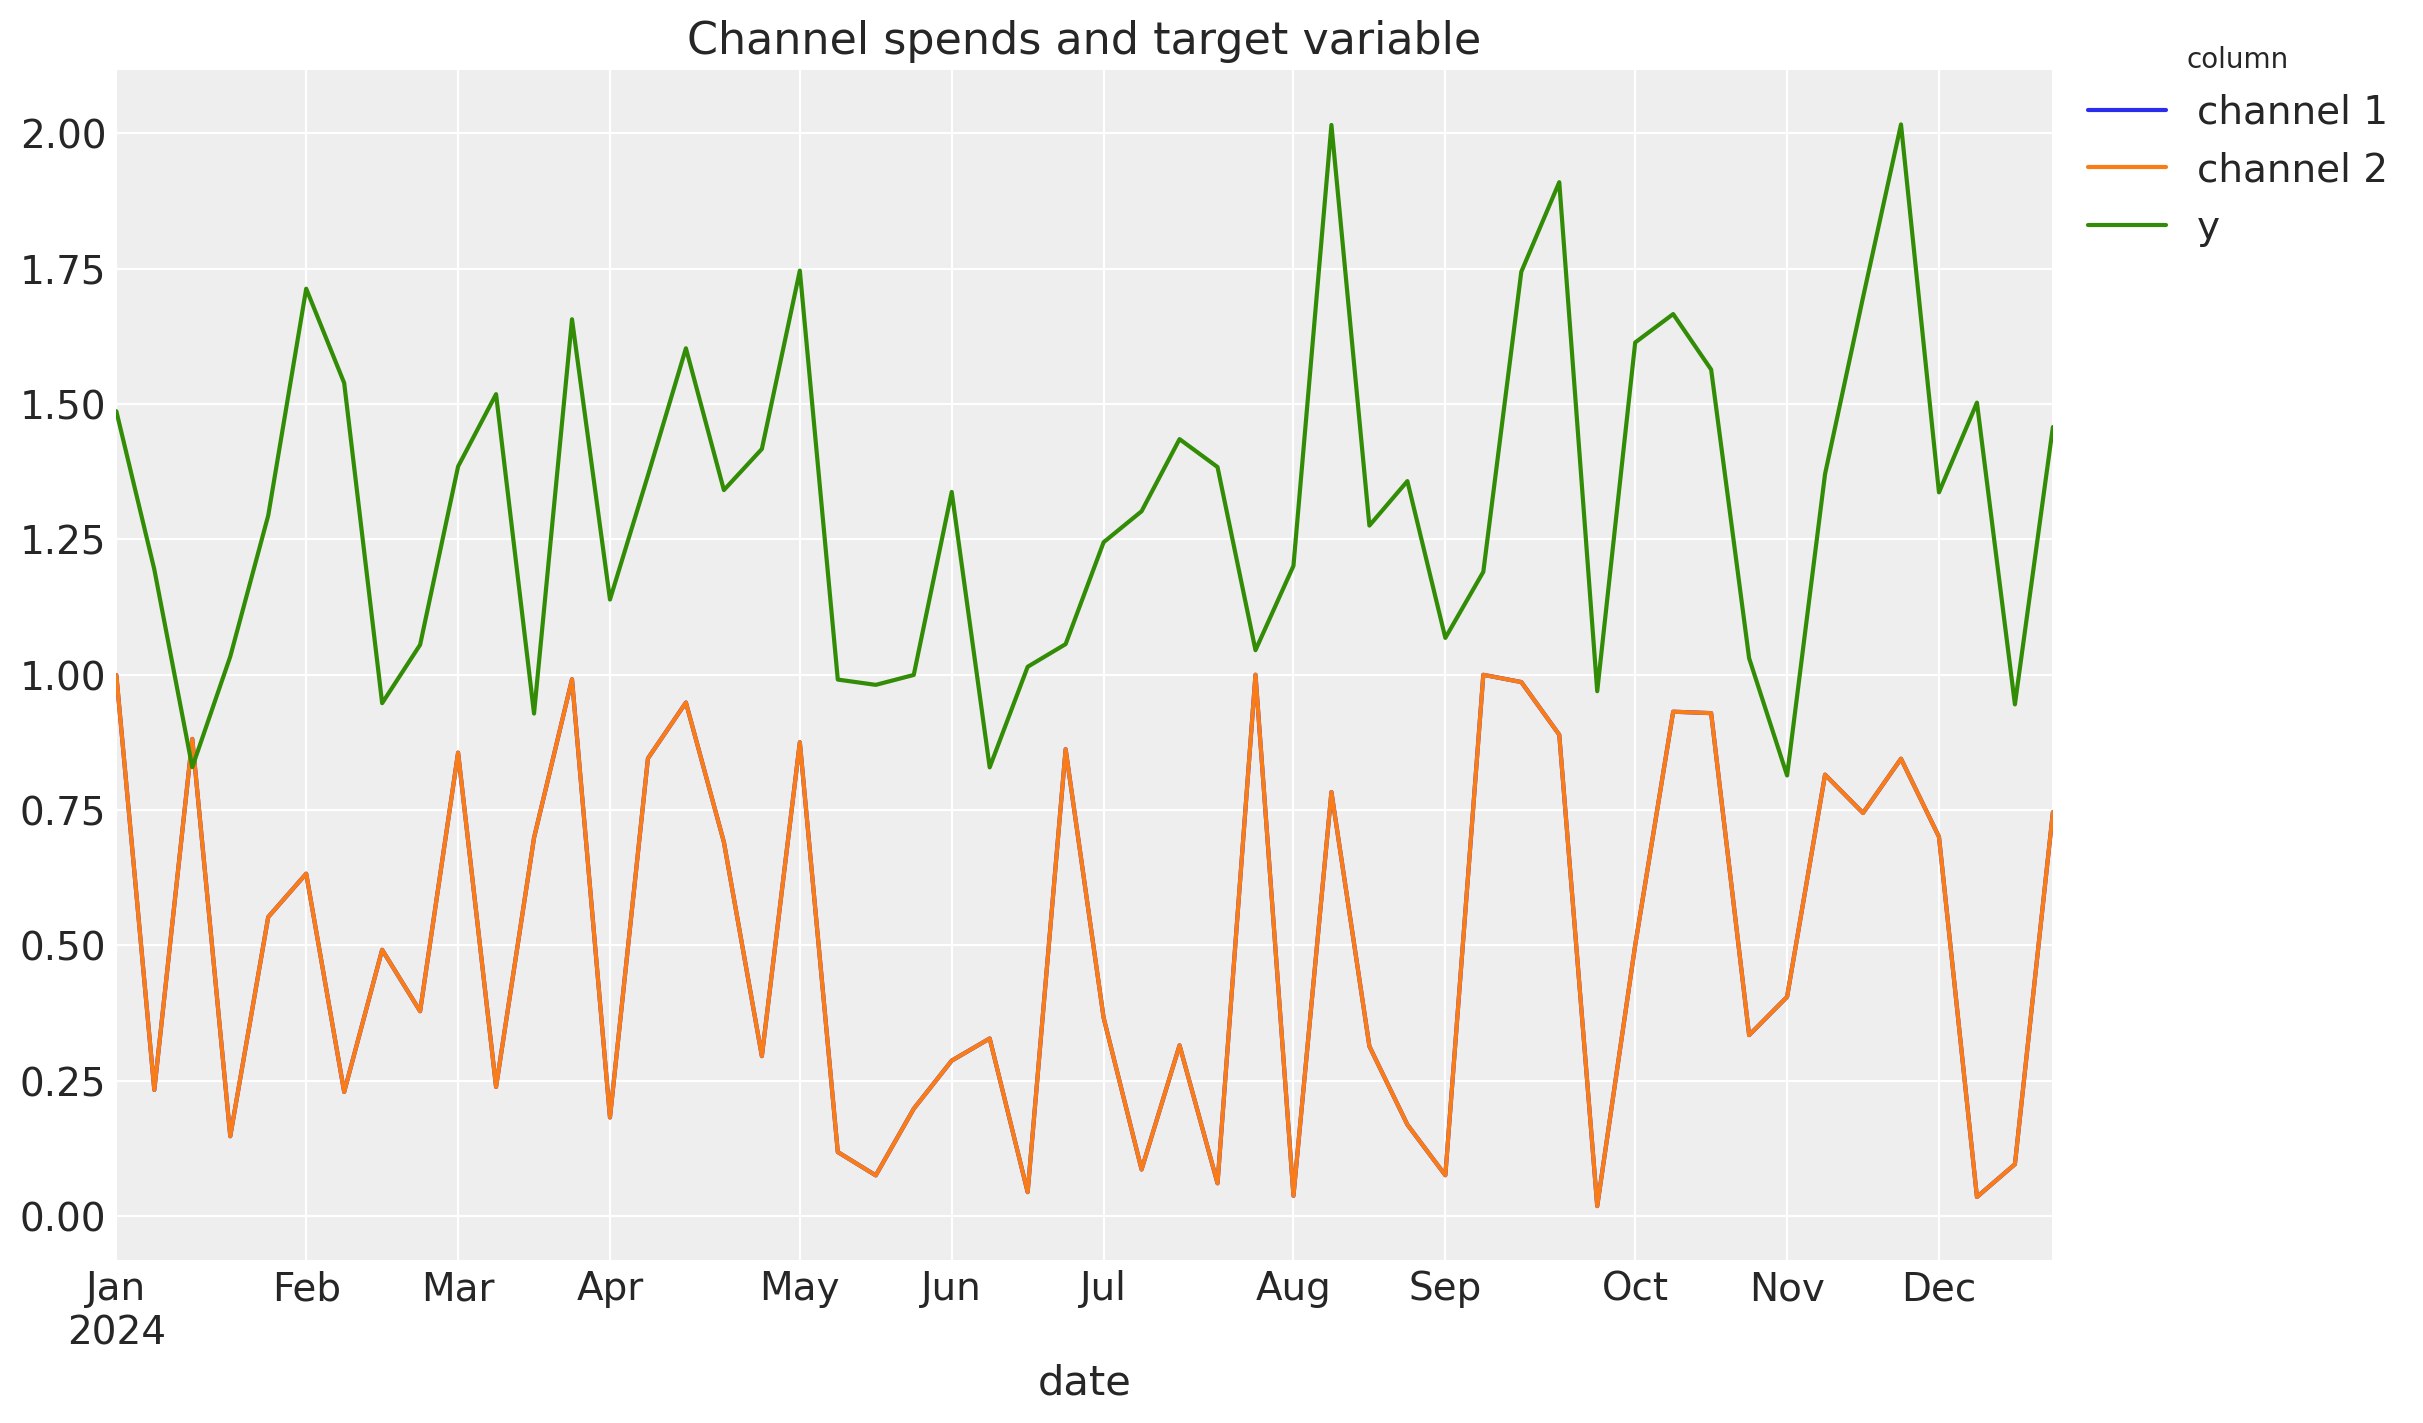

In [10]:
ax = df.set_index("date").plot(ylabel="", title="Channel spends and target variable")
ax.legend(bbox_to_anchor=(1.0, 1.05), title="column");

In [11]:
X = df.reset_index().drop("y", axis=1)
y = df["y"]

## Indistinguishable Parameter Estimates

In order to show the trouble that completely correlated channels provides, let's fit the model

In [12]:
fit_kwargs = {"nuts_sampler": "numpyro", "random_seed": rng}

idata_without = mmm.fit(X, y, **fit_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


Since the spends are completely correlated, there is no way to distinguish the parameters. Not only that, but the parameter estimates are not close to actuals.

In [13]:
def plot_true_value(value, channel: str, ax: plt.Axes, split: float = 0.42) -> plt.Axes:
    top = 2 * split
    ymin, ymax = (0, split) if channel == "channel 2" else (split, top)
    ax.axvline(value, ymin=ymin, ymax=ymax, color="black", linestyle="dashed")
    return ax

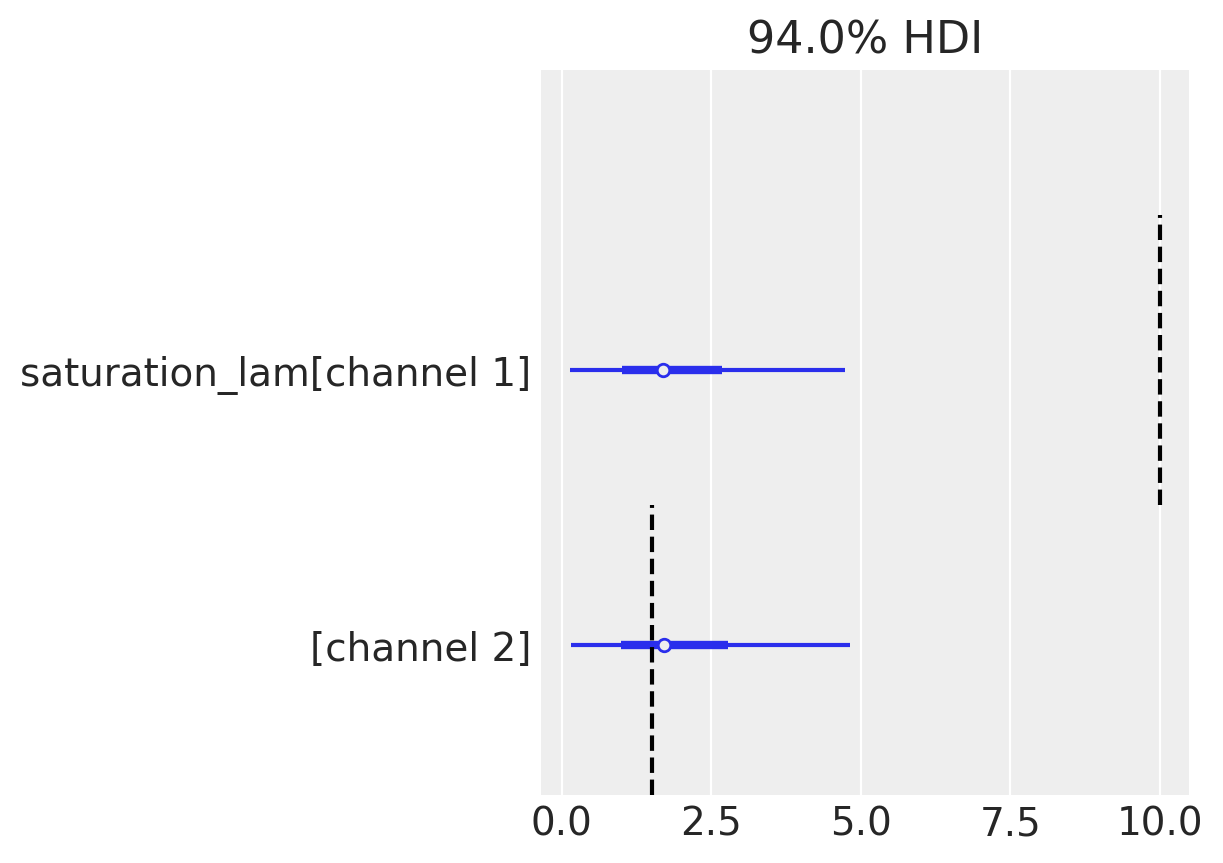

In [14]:
ax = az.plot_forest(idata_without, var_names=["saturation_lam"], combined=True)[0]

plot_true_value(true_lam_c1, "channel 1", ax=ax, split=0.4)
plot_true_value(true_lam_c2, "channel 2", ax=ax, split=0.4);

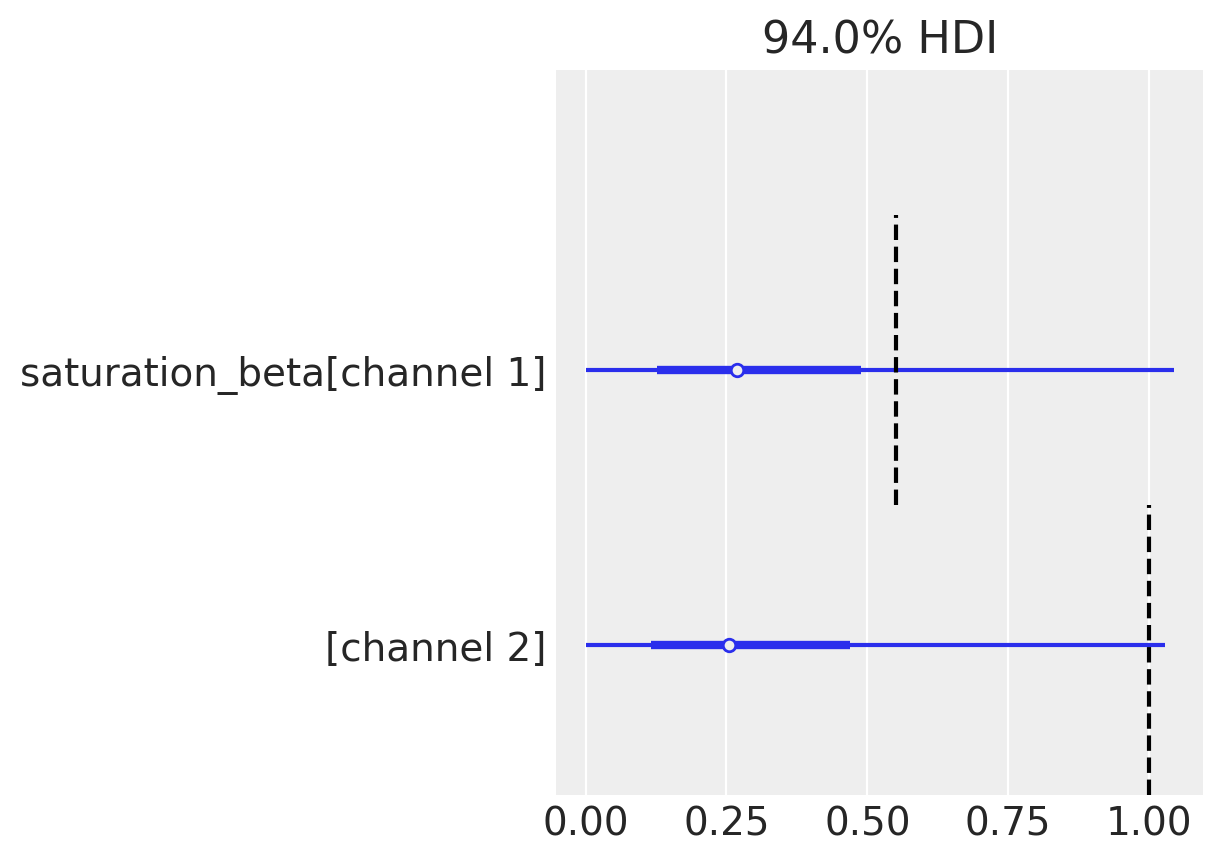

In [15]:
ax = az.plot_forest(idata_without, var_names=["saturation_beta"], combined=True)[0]

plot_true_value(true_beta_c1, "channel 1", ax=ax, split=0.4)
plot_true_value(true_beta_c2, "channel 2", ax=ax, split=0.4);

And that the direct response curve created from these parameters are completely overlapping.

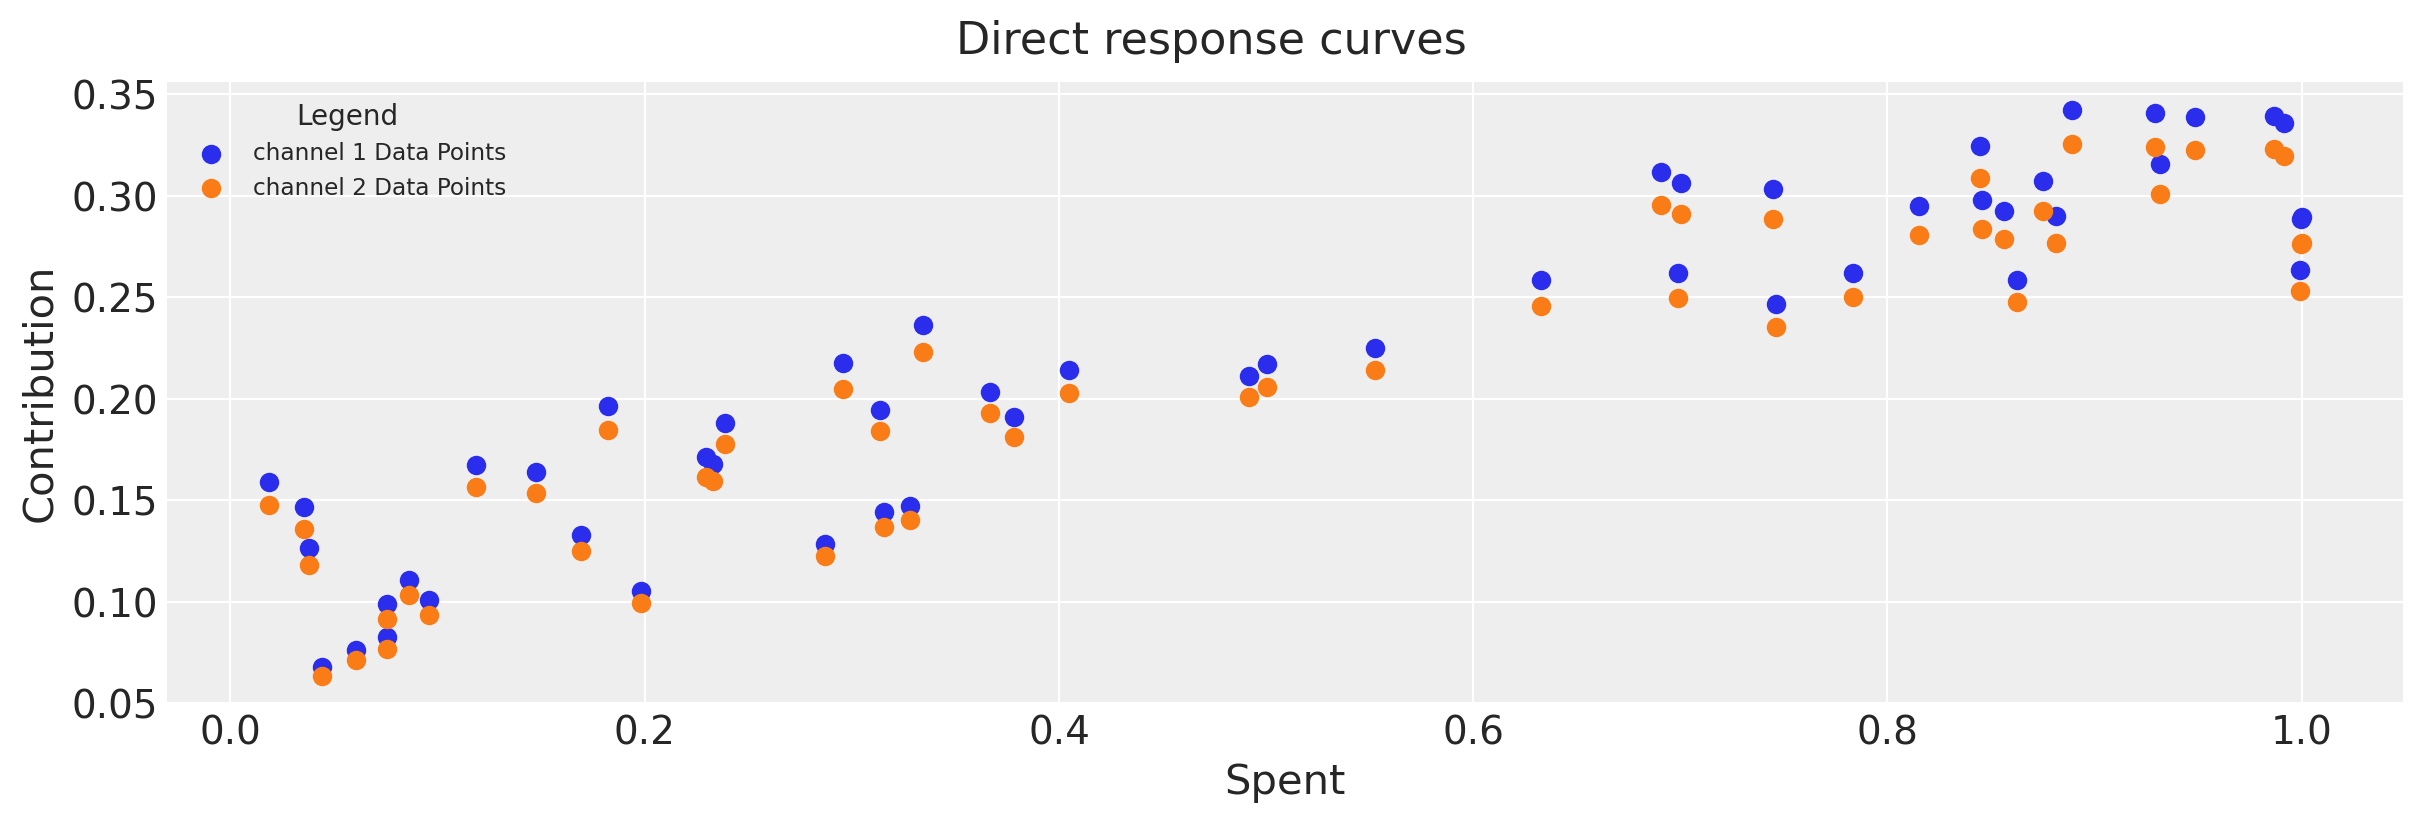

In [16]:
mmm.plot_direct_contribution_curves(same_axes=True);

## Unobserved Saturation Curves

These are the true saturation curve from our model internals. We don't observe them.

There is a difference between channels. However, it is not possible to tell with just the MMM alone.

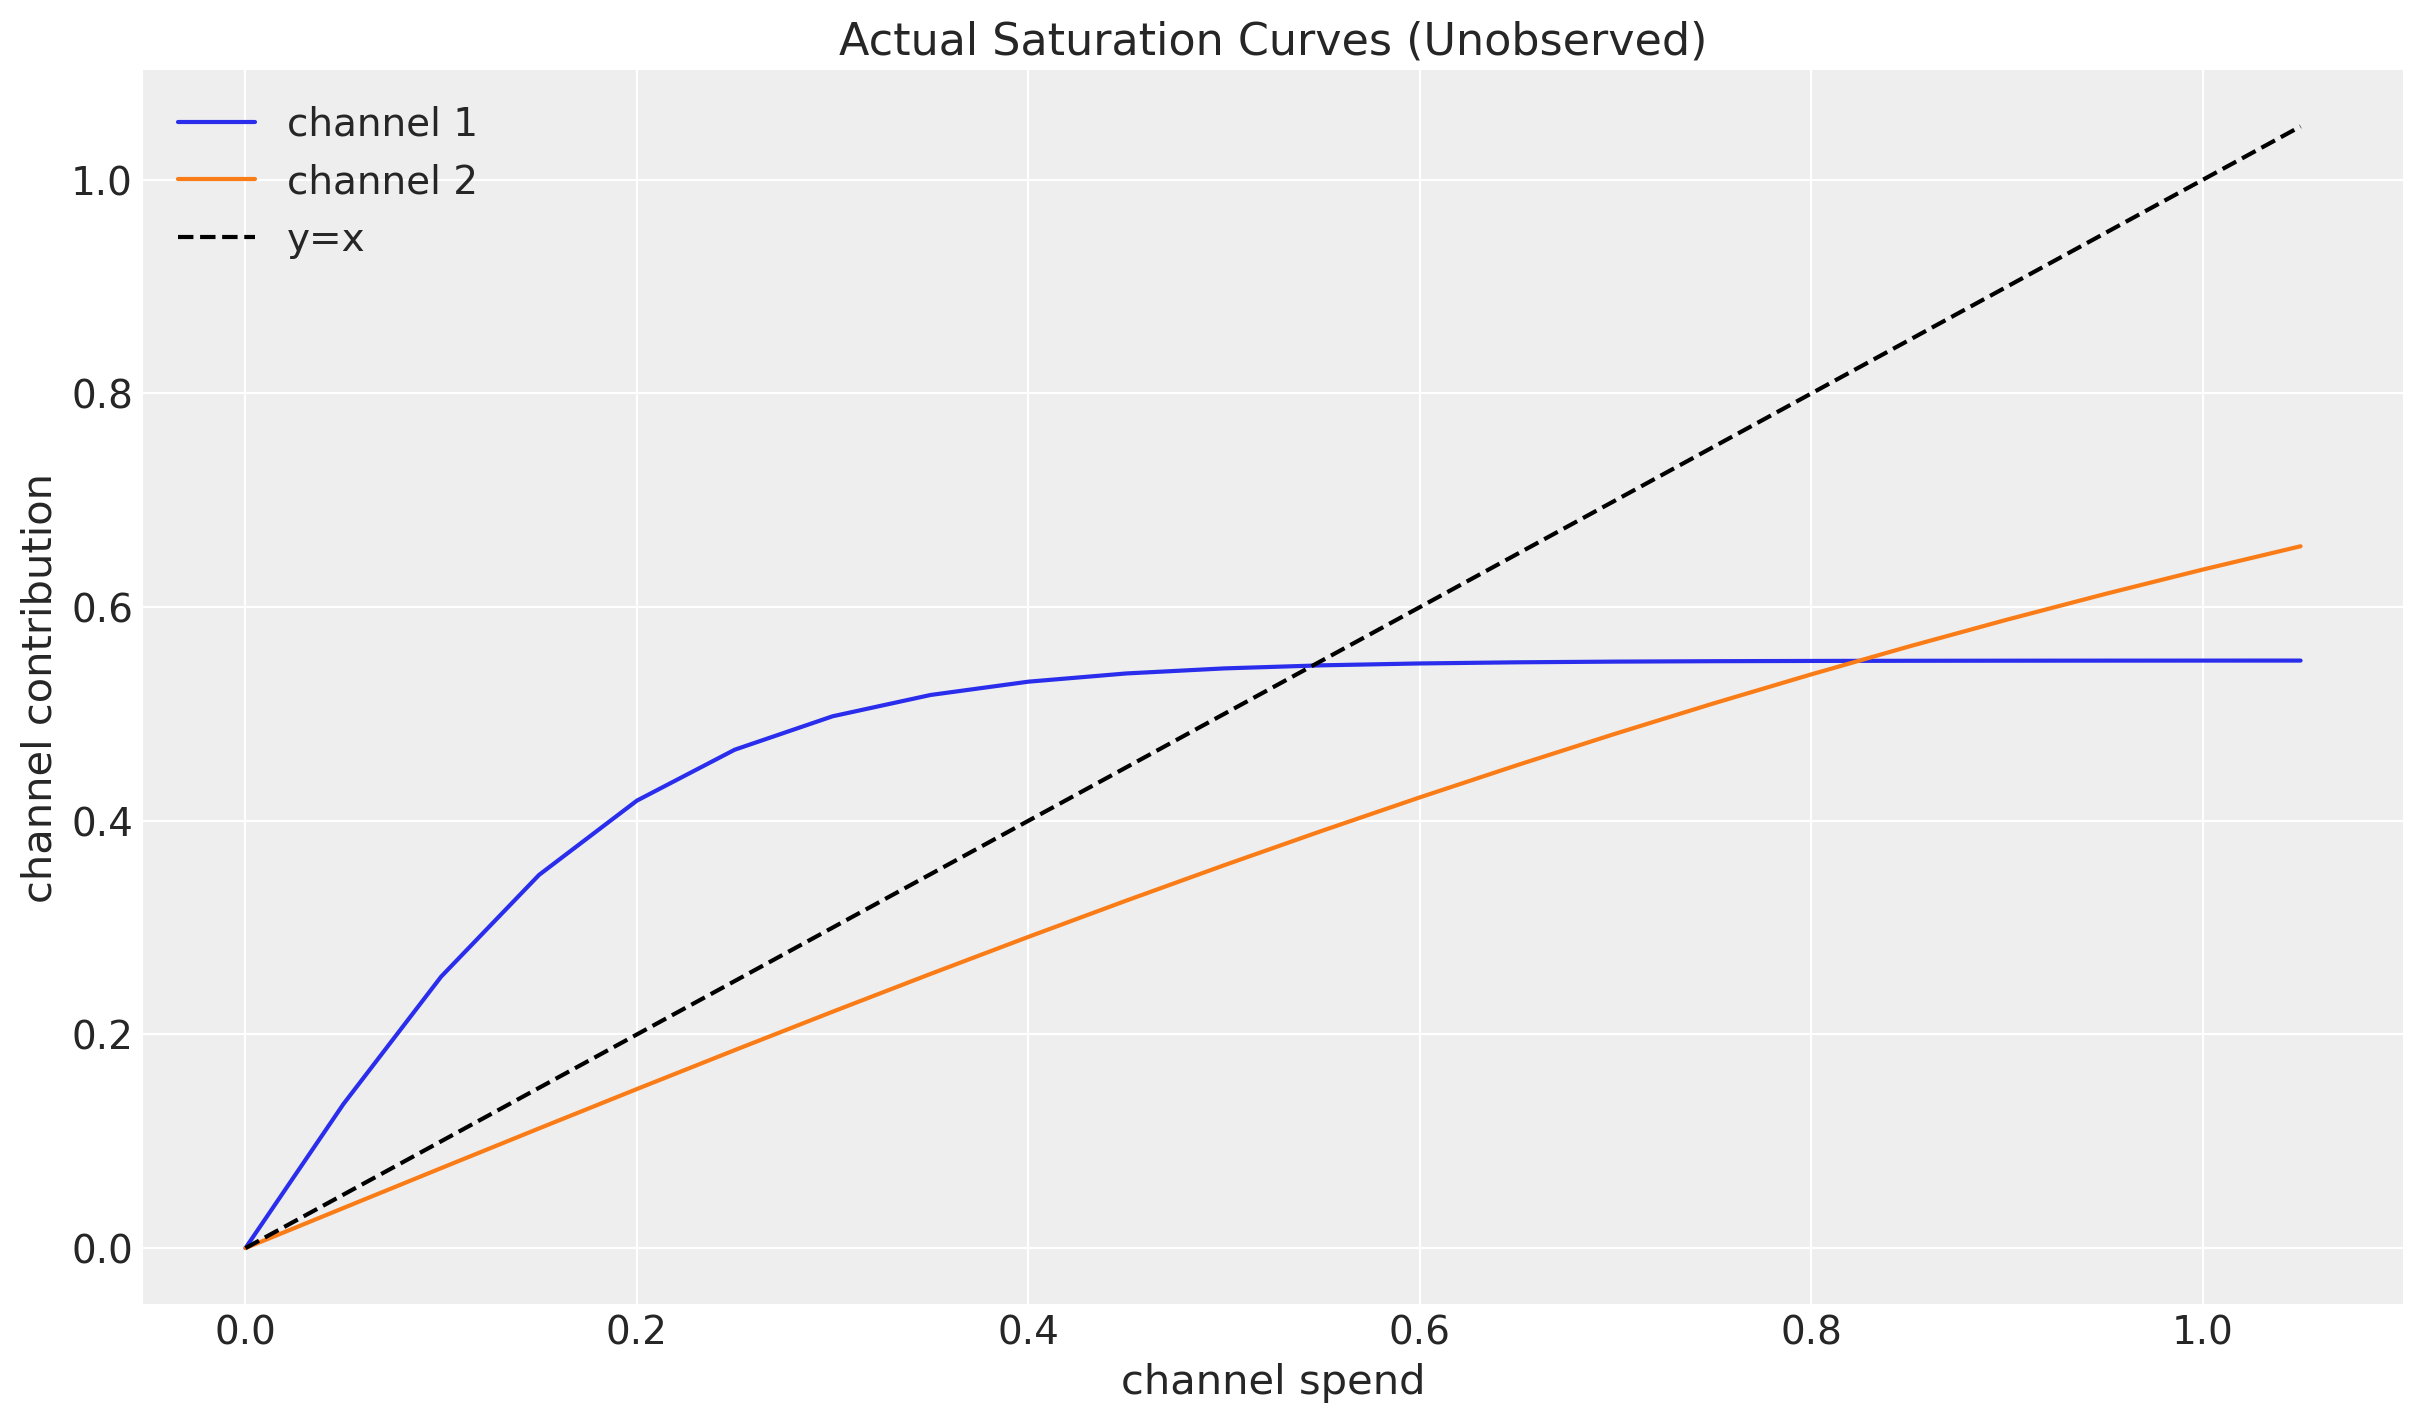

In [17]:
def saturation_function(x, lam, beta):
    return (beta * logistic_saturation(x, lam)).eval()


step_size = 0.05
xx = np.arange(0, spend.max() * 1.1, step_size)

c1_curve_fn = partial(saturation_function, lam=true_lam_c1, beta=true_beta_c1)
c2_curve_fn = partial(saturation_function, lam=true_lam_c2, beta=true_beta_c2)

c1_curve = c1_curve_fn(xx)
c2_curve = c2_curve_fn(xx)


def plot_actual_curves(ax: plt.Axes, linestyle: str | None = None) -> plt.Axes:
    ax.plot(xx, c1_curve, label="channel 1", color="C0", linestyle=linestyle)
    ax.plot(xx, c2_curve, label="channel 2", color="C1", linestyle=linestyle)

    return ax


def plot_reference(ax: plt.Axes) -> plt.Axes:
    ax.plot(xx, xx, label="y=x", color="black", linestyle="--")

    return ax


ax = plt.gca()
plot_actual_curves(ax)
plot_reference(ax)
ax.set(
    xlabel="channel spend",
    ylabel="channel contribution",
    title="Actual Saturation Curves (Unobserved)",
)
ax.legend();

## About Lift Tests

In a lift study, one temporarily changes the budget of a channel for a fixed period of time, and then uses some method (for example CausalPy) to make inference about the change in sales directly caused by the adjustment.

A lift test is characterized by:

- `channel`: the channel that was tested
- `x`: pre-test channel spend
- `delta_x`: change made to `x`
- `delta_y`: inferred change in sales due to `delta_x`
- `sigma`: standard deviation of `delta_y`

An experiment characterized in this way can be viewed as two points on the saturation curve for the channel. Accordingly, lift test calibration is implemented by adding a term to the model likelihood, that makes the channel saturation curve (the contribution as a function of spend) align with the test observation.

In [18]:
def create_lift_test_from_actual_curve(
    channel: str, x: float, delta_x: float, sigma: float
) -> dict[str, float]:
    curve_fn = c1_curve_fn if channel == "channel 1" else c2_curve_fn

    delta_y = curve_fn(x + delta_x) - curve_fn(x)

    return {
        "channel": channel,
        "x": x,
        "delta_x": delta_x,
        "delta_y": delta_y,
        "sigma": sigma,
    }

In [19]:
df_lift_test = pd.DataFrame(
    [
        # Channel x1
        create_lift_test_from_actual_curve("channel 1", 0.0, 0.05, 0.05),
        create_lift_test_from_actual_curve("channel 1", 0.15, 0.05, 0.05),
        create_lift_test_from_actual_curve("channel 1", 0.3, 0.05, 0.05),
        # Channel x2
        create_lift_test_from_actual_curve("channel 2", 0.5, 0.05, 0.10),
    ]
)

df_lift_test

,channel,x,delta_x,delta_y,sigma
0,channel 1,0.00,0.05,0.134705,0.05
1,channel 1,0.15,0.05,0.069545,0.05
2,channel 1,0.30,0.05,0.019925,0.05
3,channel 2,0.50,0.05,0.032236,0.10


In [20]:
def plot_triangle(
    x,
    delta_x,
    delta_y,
    color: str,
    ax: plt.Axes,
    offset: float = 0,
    label: str | None = None,
) -> plt.Axes:
    x_after = x + delta_x

    y = offset
    y_after = y + delta_y

    ax.plot([x, x_after], [y, y], color=color, label=label)
    ax.plot([x_after, x_after], [y, y_after], color=color)
    ax.plot([x, x_after], [y, y_after], color=color, linestyle="dashed")

    return ax


def plot_channel_triangles(
    df: pd.DataFrame, color: str, ax: plt.Axes, label: str
) -> plt.Axes:
    kwargs = {"label": label}
    for _, row in df.iterrows():
        plot_triangle(
            row["x"], row["delta_x"], row["delta_y"], ax=ax, color=color, **kwargs
        )
        if "label" in kwargs:
            kwargs.pop("label")
    return ax


def plot_lift_test_triangles(df: pd.DataFrame, ax: plt.Axes) -> plt.Axes:
    idx = df["channel"] == "channel 1"
    plot_channel_triangles(df.loc[idx], color="C0", ax=ax, label="channel 1")
    plot_channel_triangles(df.loc[~idx], color="C1", ax=ax, label="channel 2")
    return ax

Below we are visualizing each lift test observation as a triangle. The base of the triangle shows the change in the spend and height of triangle is change in contribution. Each base is at y=0 since only the change in contribution is observed.

Even though these are not the saturation curve, they can be used to better estimate the saturation curve. We can see that channel 2 is slower to saturation since the change in y is larger for higher x values.

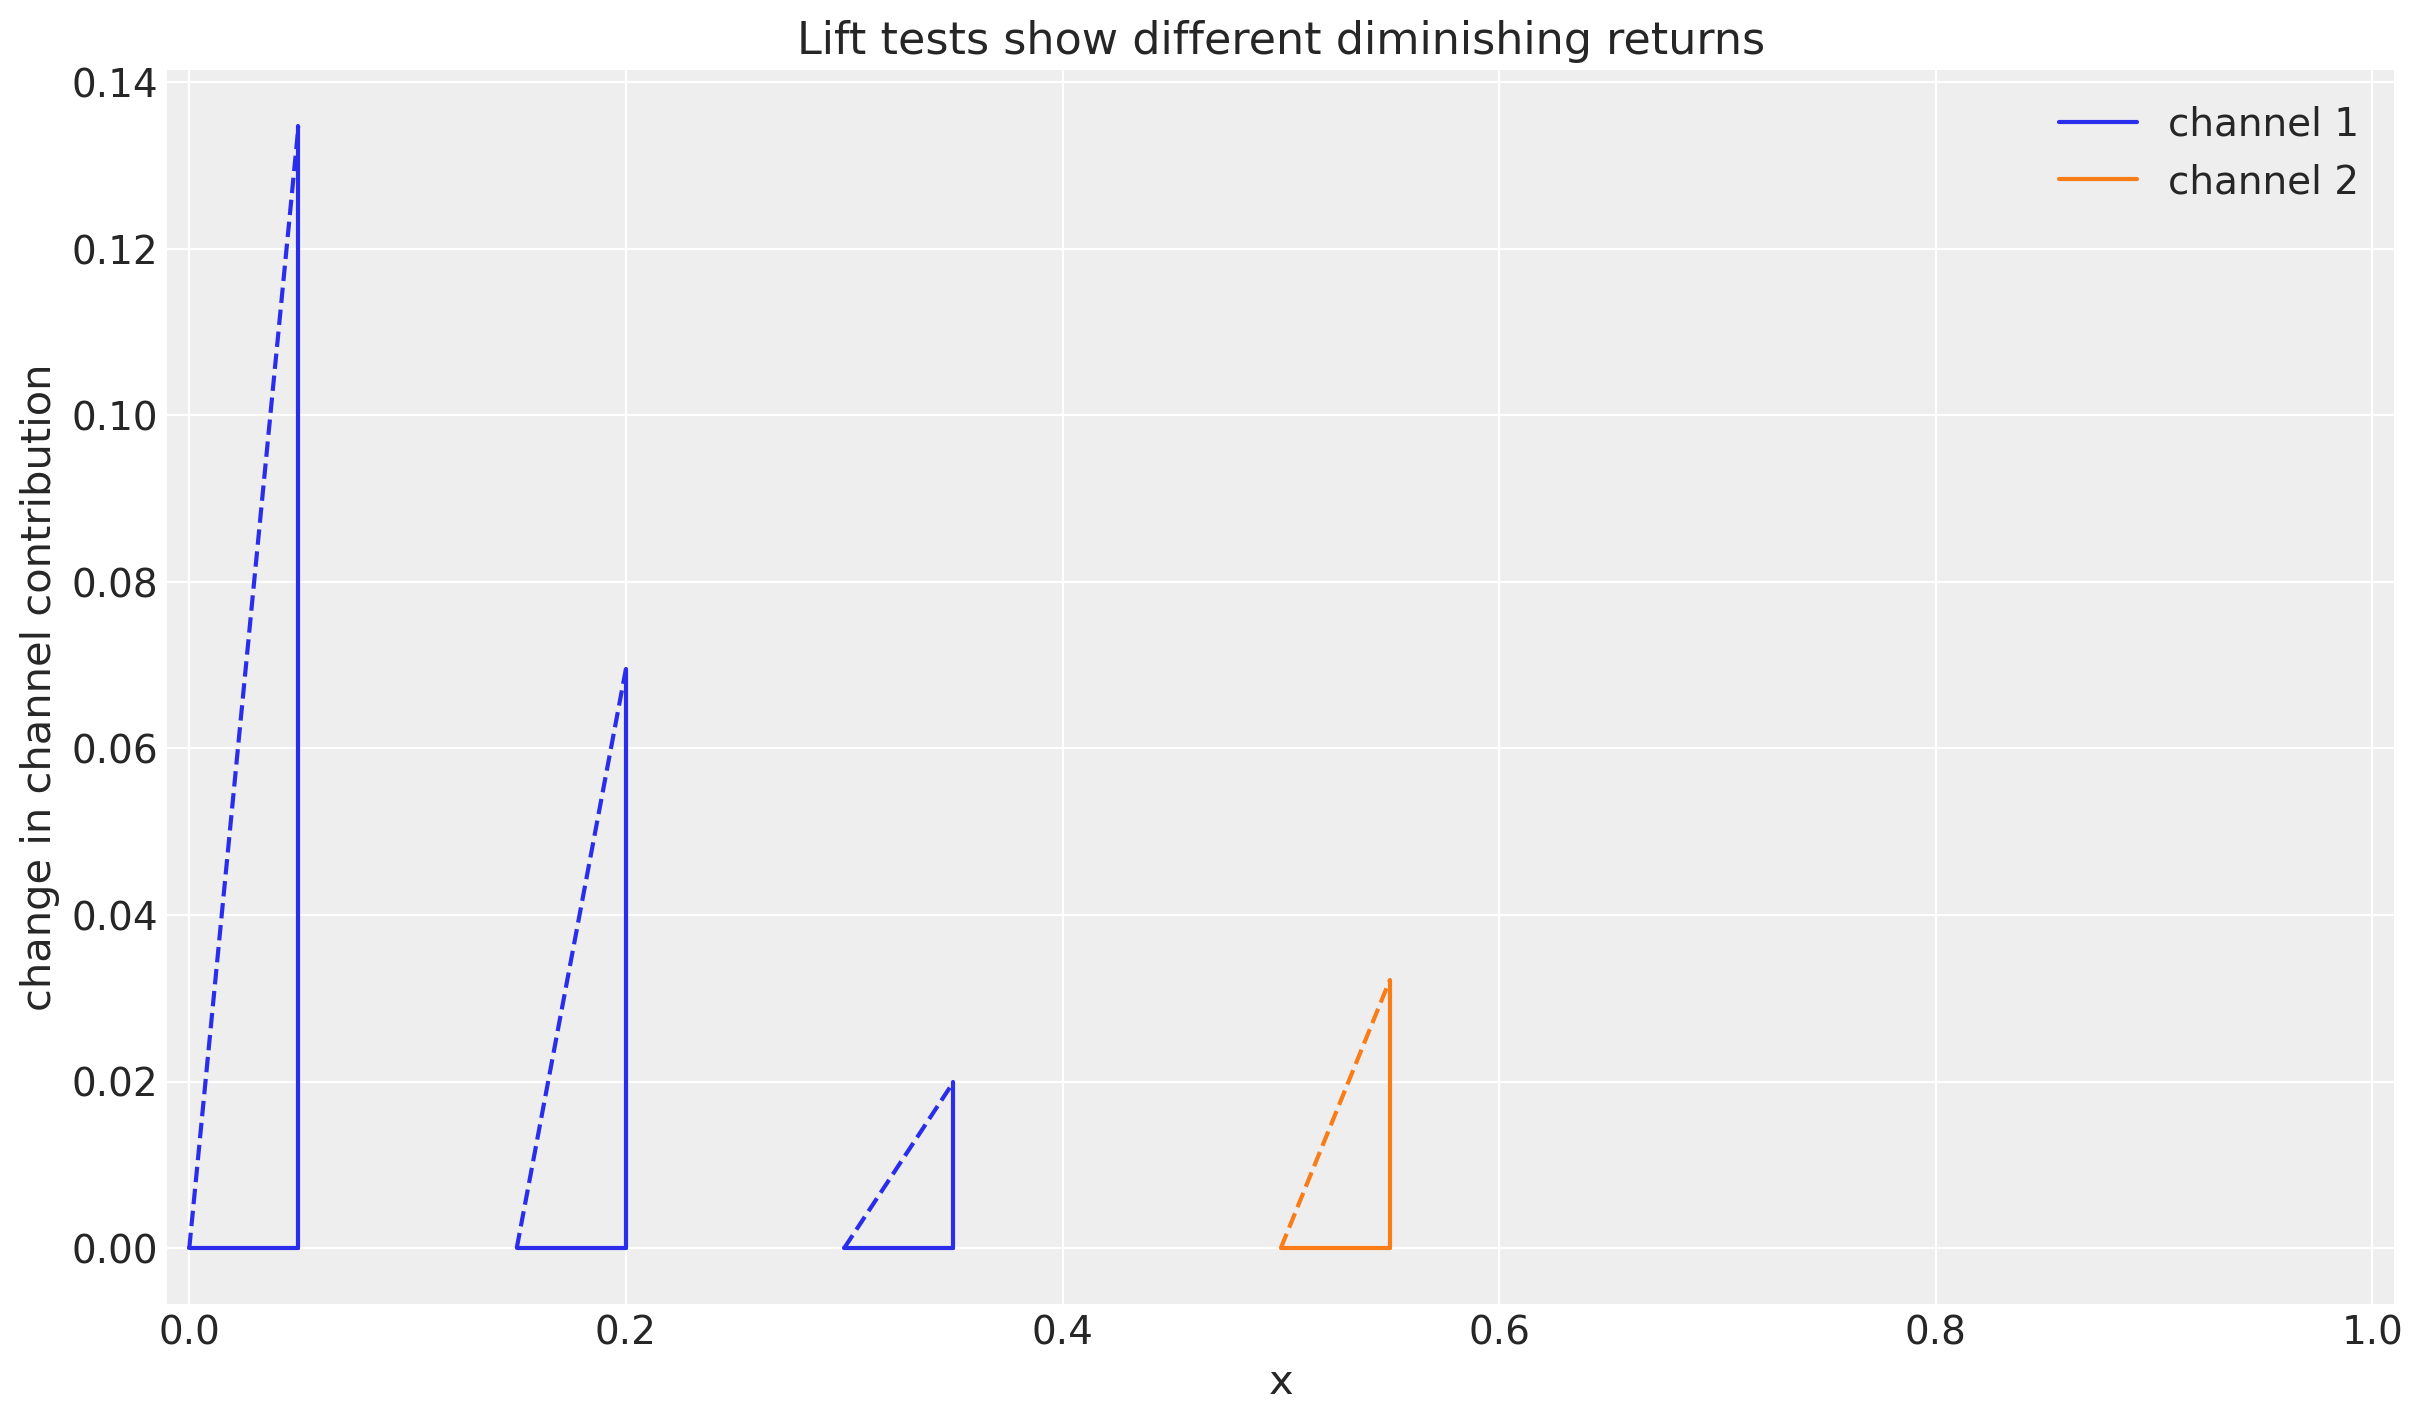

In [21]:
ax = plt.gca()
plot_lift_test_triangles(df_lift_test, ax=ax)
ax.legend()
ax.set(
    xlim=(-0.01, 1.01),
    xlabel="x",
    ylabel="change in channel contribution",
    title="Lift tests show different diminishing returns",
);

## Add Lift Tests to Model

Having created a `MMM` model instance, `mmm` and built it using the `build_model` method or fit with `fit` method, we can add lift test results to the model using the `add_lift_test_measurments` method.

In [22]:
mmm.add_lift_test_measurements(df_lift_test)

We can see the model graph is modified with new observation for our lift measurements. 

The observation distribution is assumed to be `Gamma` as each saturation curve is monotonically increasing given a set of parameters.

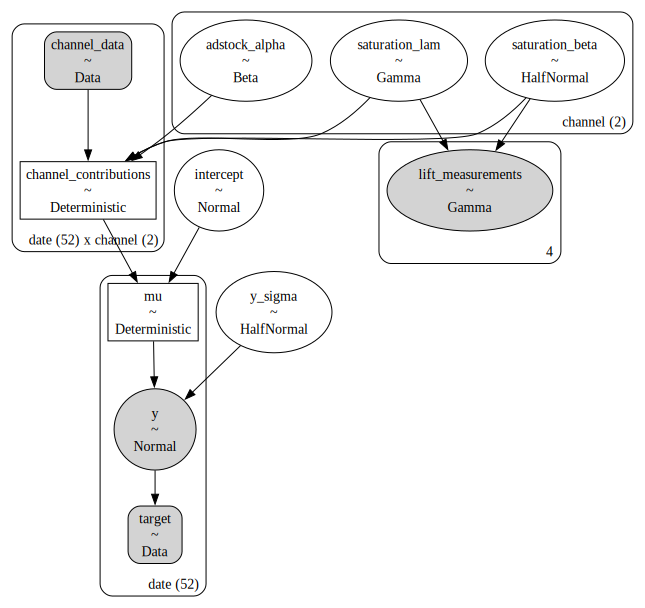

In [23]:
pm.model_to_graphviz(mmm.model)

We can refit the model but with the lift tests included

In [24]:
idata_with = mmm.fit(X, y, **fit_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


The model gets shaped by the lift test measurements and the response curves begin to separate!

In [25]:
def plot_channel_rug(
    df: pd.DataFrame, color: str, ax: plt.Axes, height: float
) -> plt.Axes:
    for x in df["x"].to_numpy():
        ax.axvline(x, ymin=0, ymax=height, color=color)
    return ax


def plot_lift_test_rug(df, ax, height: float = 0.05) -> plt.Axes:
    idx = df["channel"] == "channel 1"
    plot_channel_rug(df.loc[idx], color="C0", ax=ax, height=height)
    plot_channel_rug(df.loc[~idx], color="C1", ax=ax, height=height)

    return ax

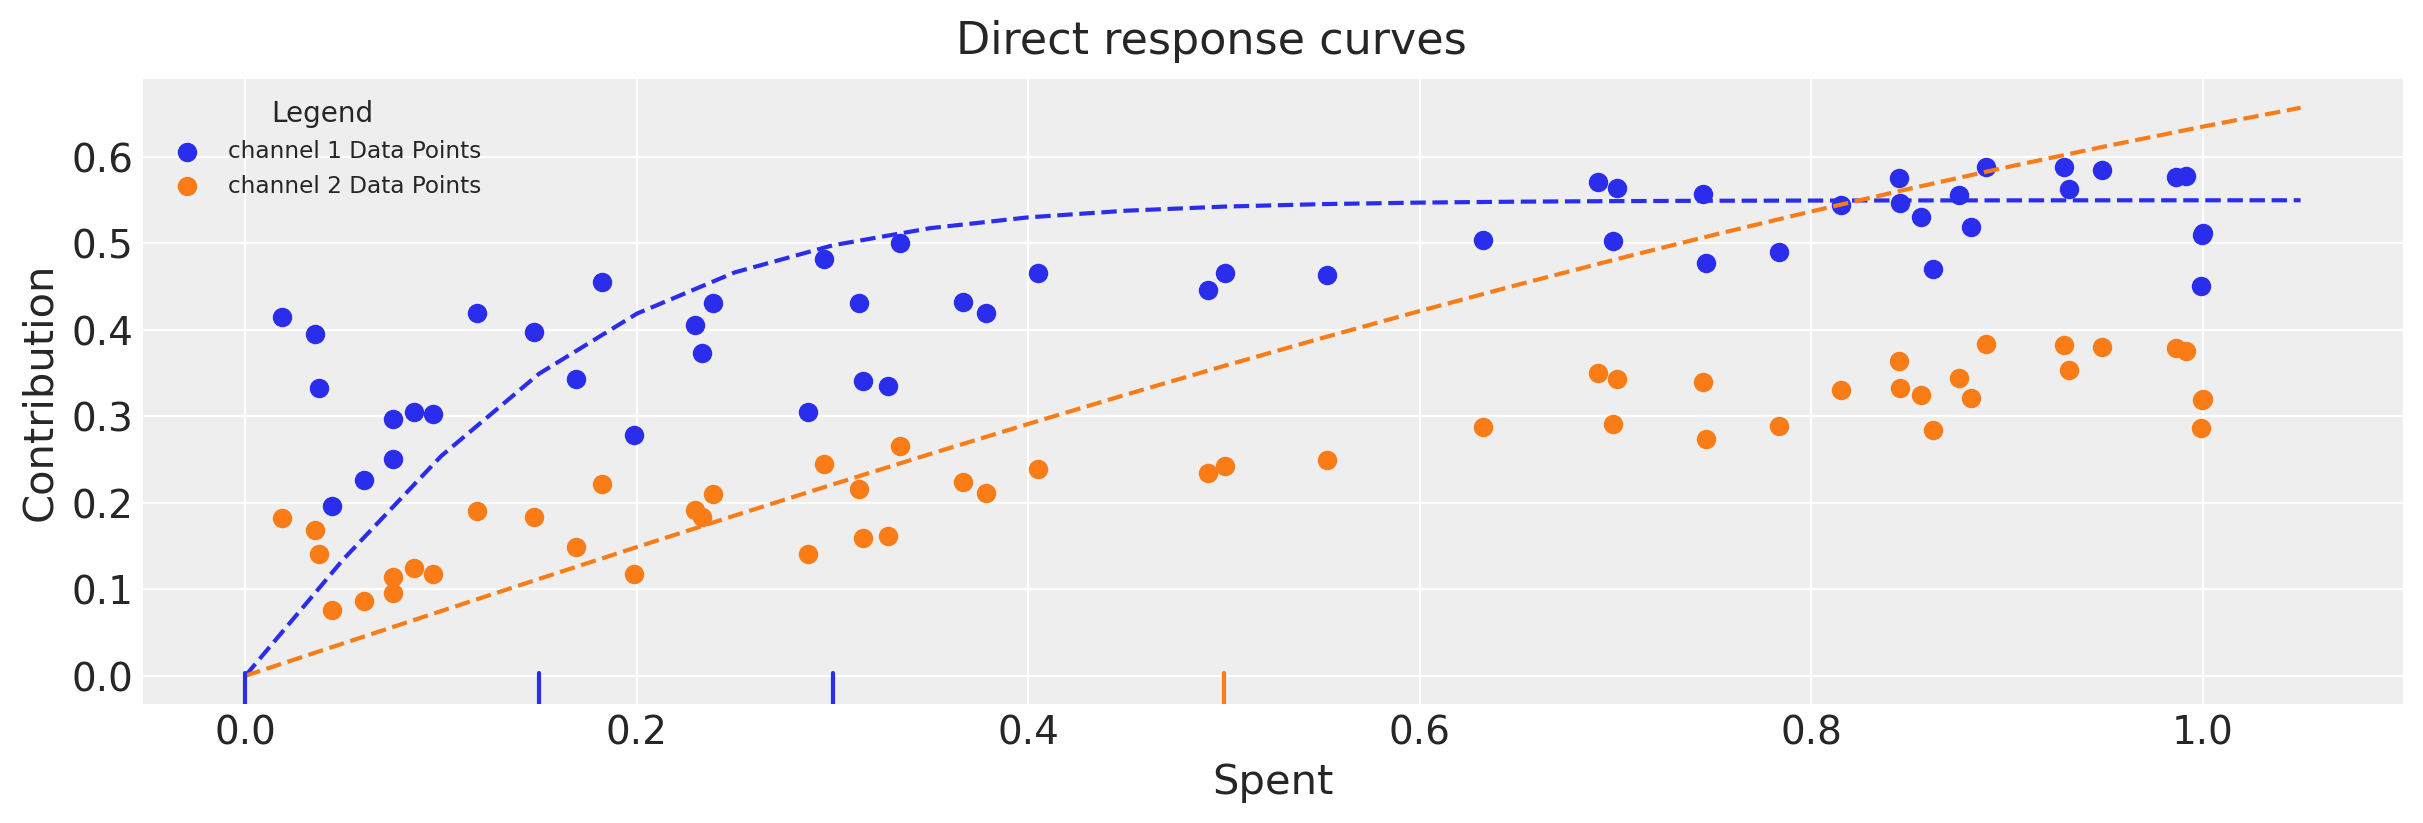

In [26]:
fig = mmm.plot_direct_contribution_curves(same_axes=True)
ax = fig.axes[0]
plot_actual_curves(ax=ax, linestyle="dashed")
plot_lift_test_rug(df_lift_test, ax);

This can be seen in the parameter estimates that make up this response curve

In [27]:
def plot_comparison(data, model_names, var_name: str) -> plt.Axes:
    return az.plot_forest(
        data,
        model_names=model_names,
        var_names=[var_name],
        combined=True,
    )[0]

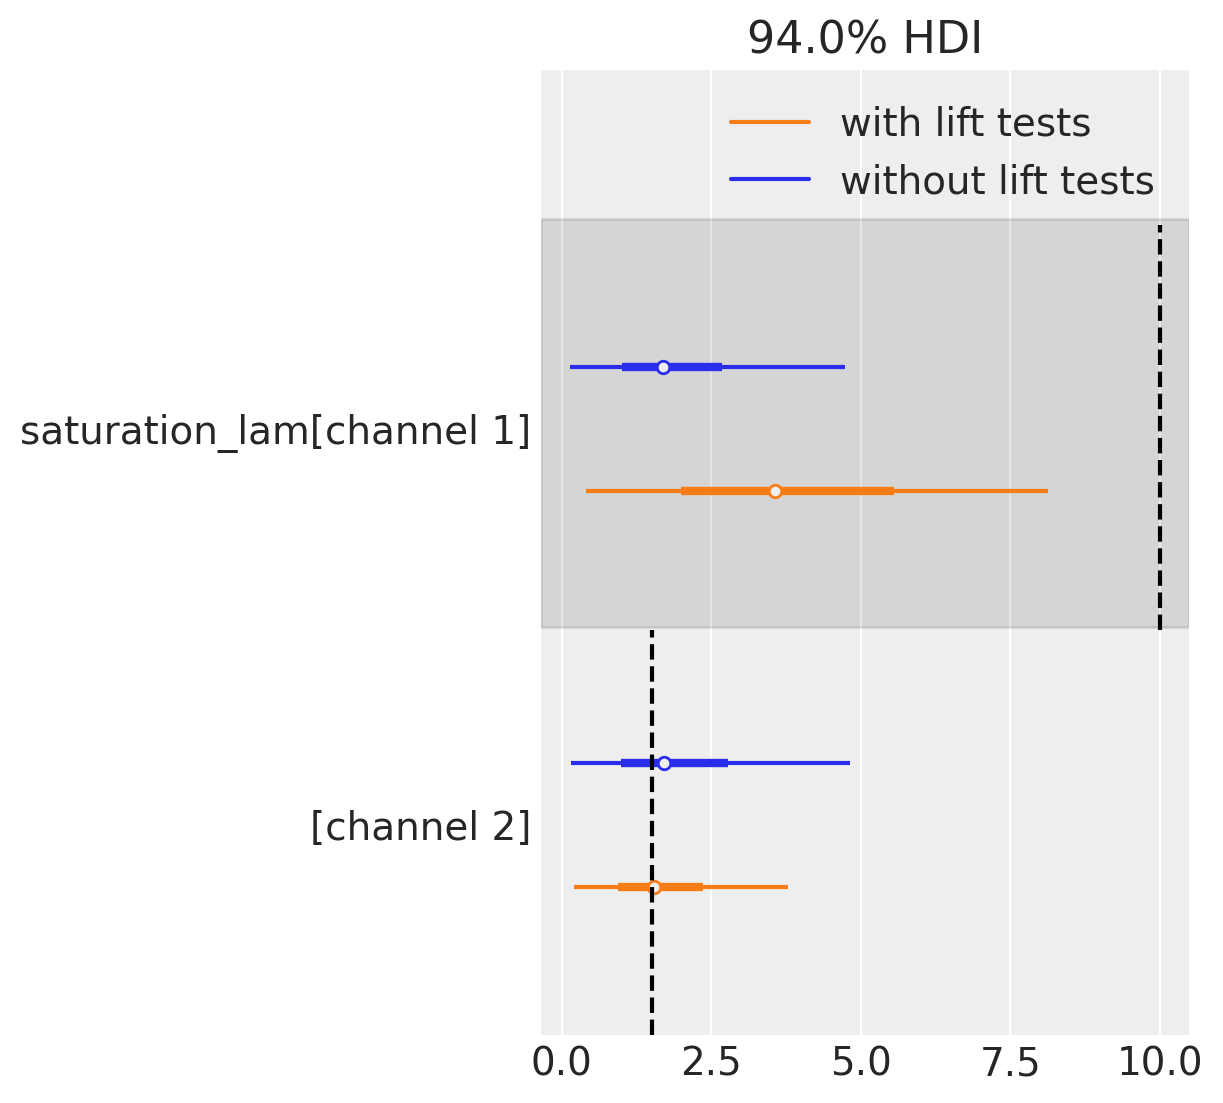

In [28]:
data = [idata_without, idata_with]
model_names = ["without lift tests", "with lift tests"]

ax = plot_comparison(data, model_names, "saturation_lam")
plot_true_value(true_lam_c1, "channel 1", ax)
plot_true_value(true_lam_c2, "channel 2", ax);

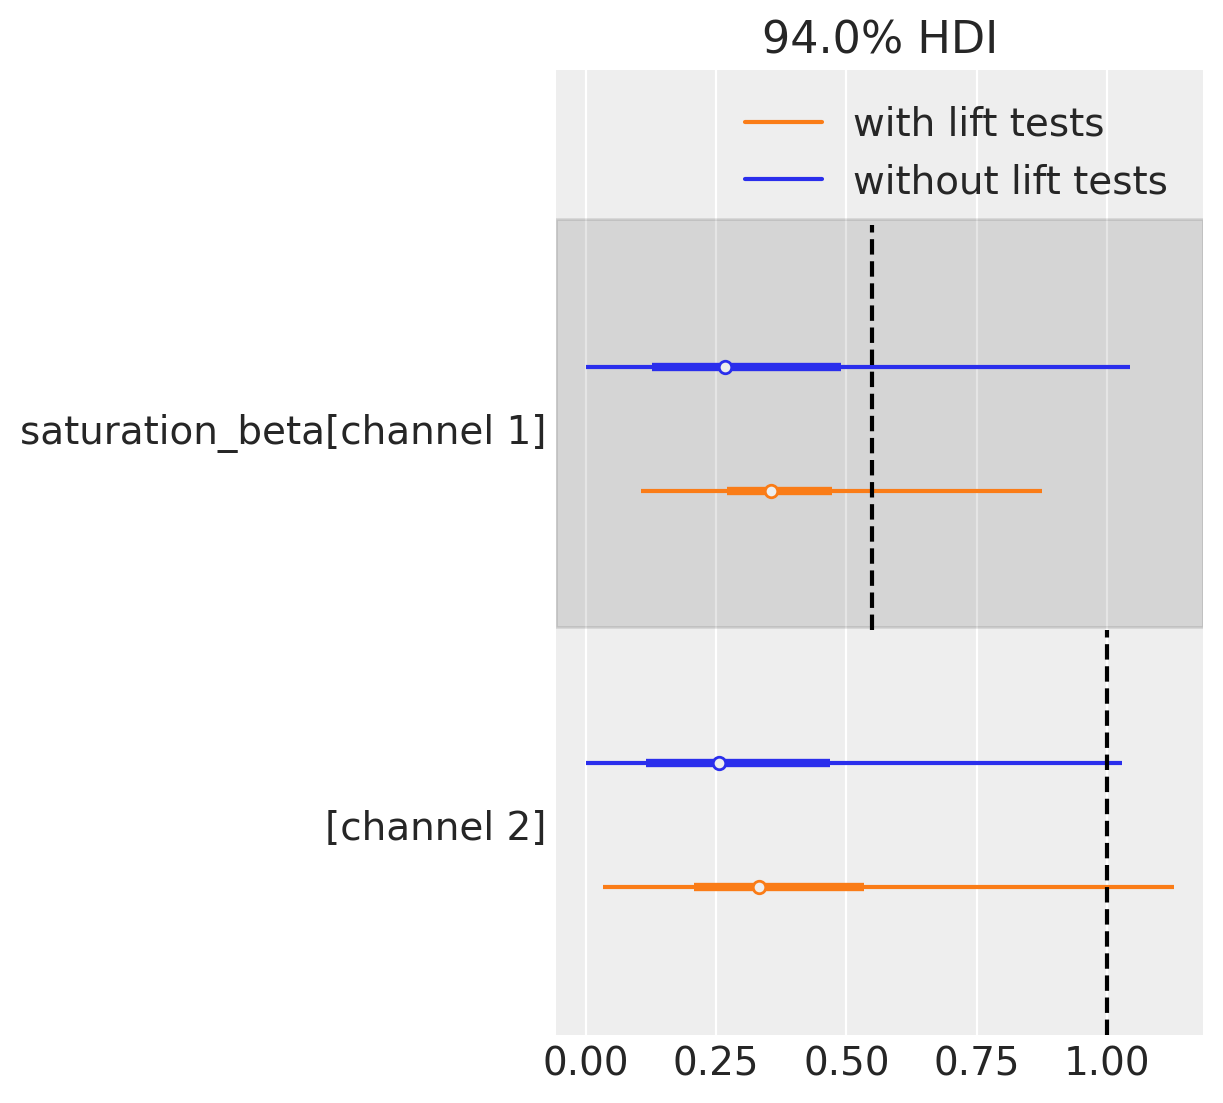

In [29]:
ax = plot_comparison(data, model_names, "saturation_beta")
plot_true_value(true_beta_c1, "channel 1", ax)
plot_true_value(true_beta_c2, "channel 2", ax);

## Add Additional Lift Tests

We can add even more lift tests.

They can either all be added at one time or separately. Use the `name` parameter in order to separate the two sets of observations in the model graph.

In [30]:
df_additional_lift_test = pd.DataFrame(
    [
        # More for Channel x1
        create_lift_test_from_actual_curve("channel 1", 0.1, 0.05, sigma=0.01),
        create_lift_test_from_actual_curve("channel 1", 0.5, 0.05, sigma=0.01),
        # More for channel x2
        create_lift_test_from_actual_curve("channel 2", 0.3, 0.05, sigma=0.01),
    ]
)

df_additional_lift_test

,channel,x,delta_x,delta_y,sigma
0,channel 1,0.1,0.05,0.095167,0.01
1,channel 1,0.5,0.05,0.002885,0.01
2,channel 2,0.3,0.05,0.035354,0.01


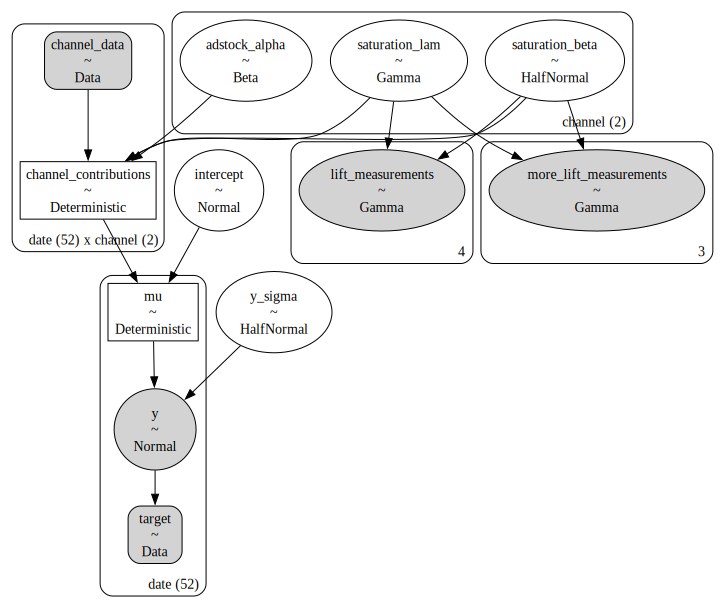

In [31]:
mmm.add_lift_test_measurements(df_additional_lift_test, name="more_lift_measurements")

pm.model_to_graphviz(mmm.model)

In [32]:
idata_with_more = mmm.fit(X, y, **fit_kwargs)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The response curve is shifting more and more

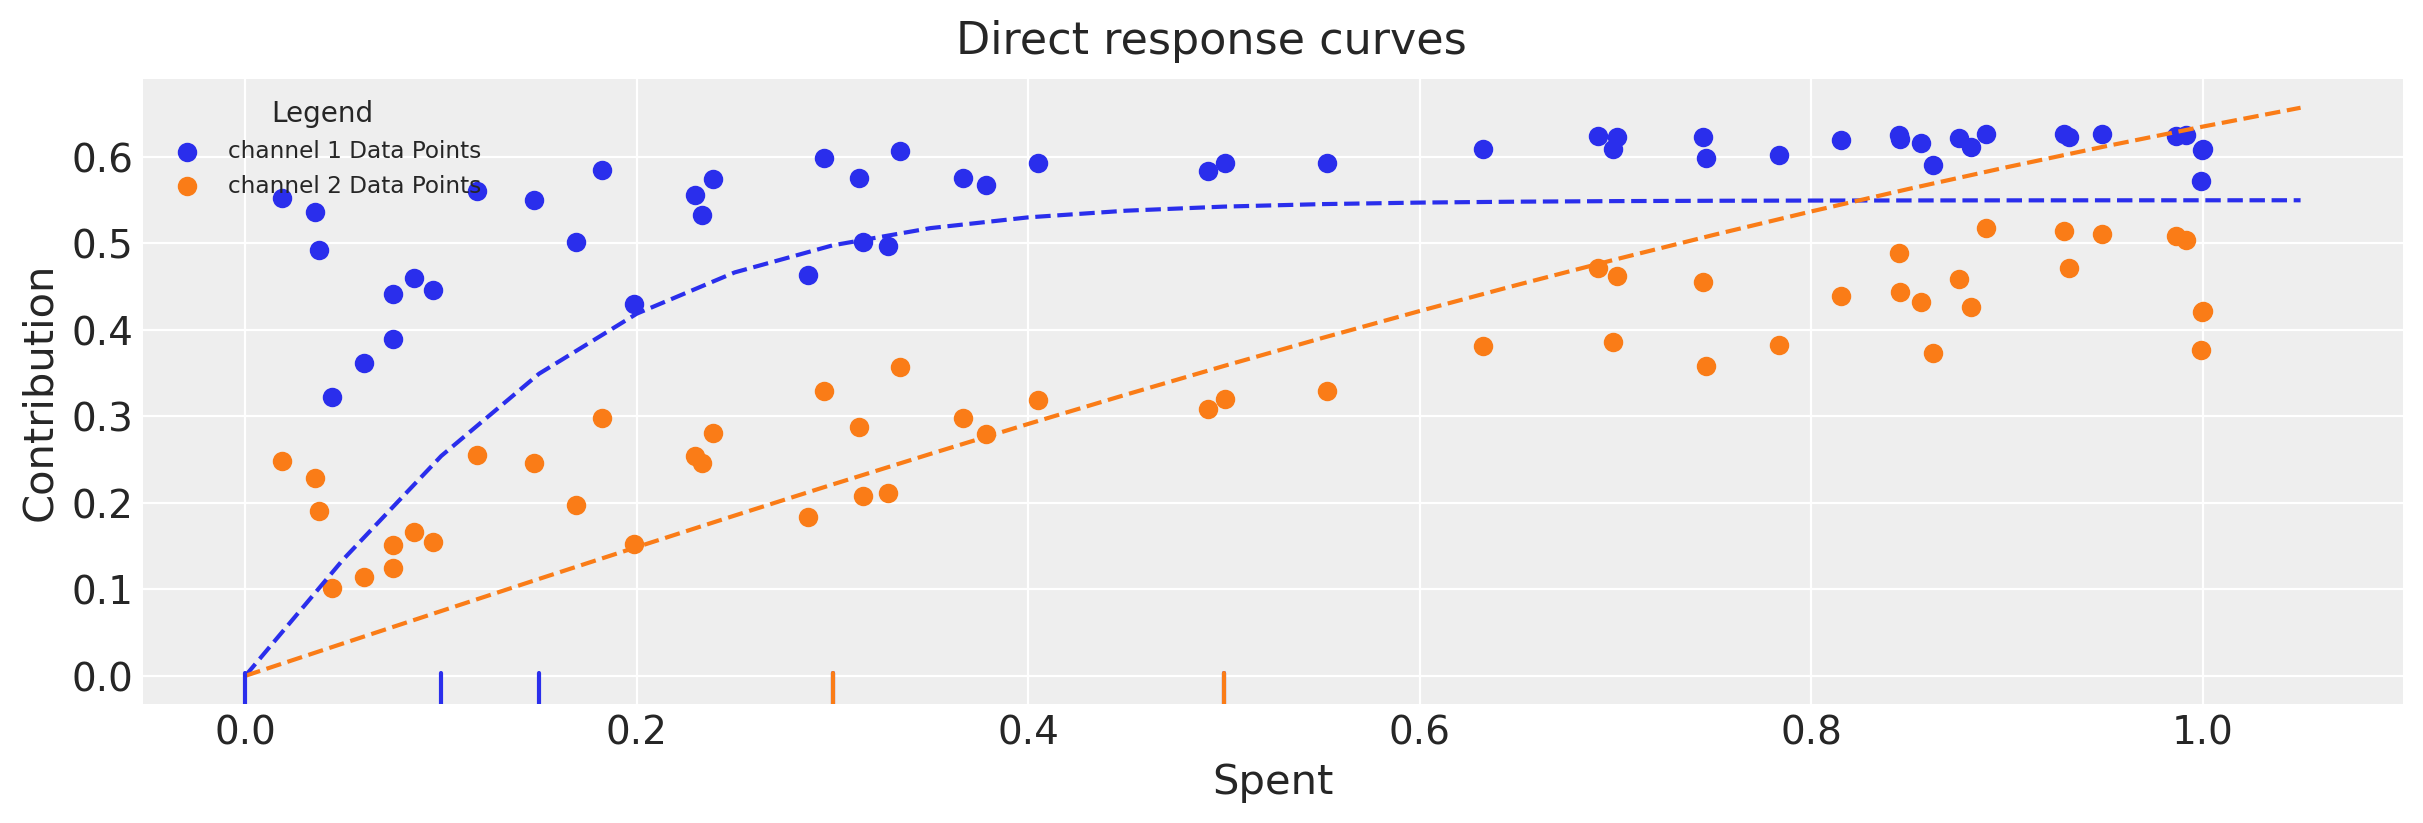

In [33]:
df_all_lift_tests = pd.concat([df_lift_test, df_additional_lift_test])

fig = mmm.plot_direct_contribution_curves(same_axes=True)
ax = fig.axes[0]
plot_actual_curves(ax=ax, linestyle="dashed")
plot_lift_test_rug(df_all_lift_tests, ax);

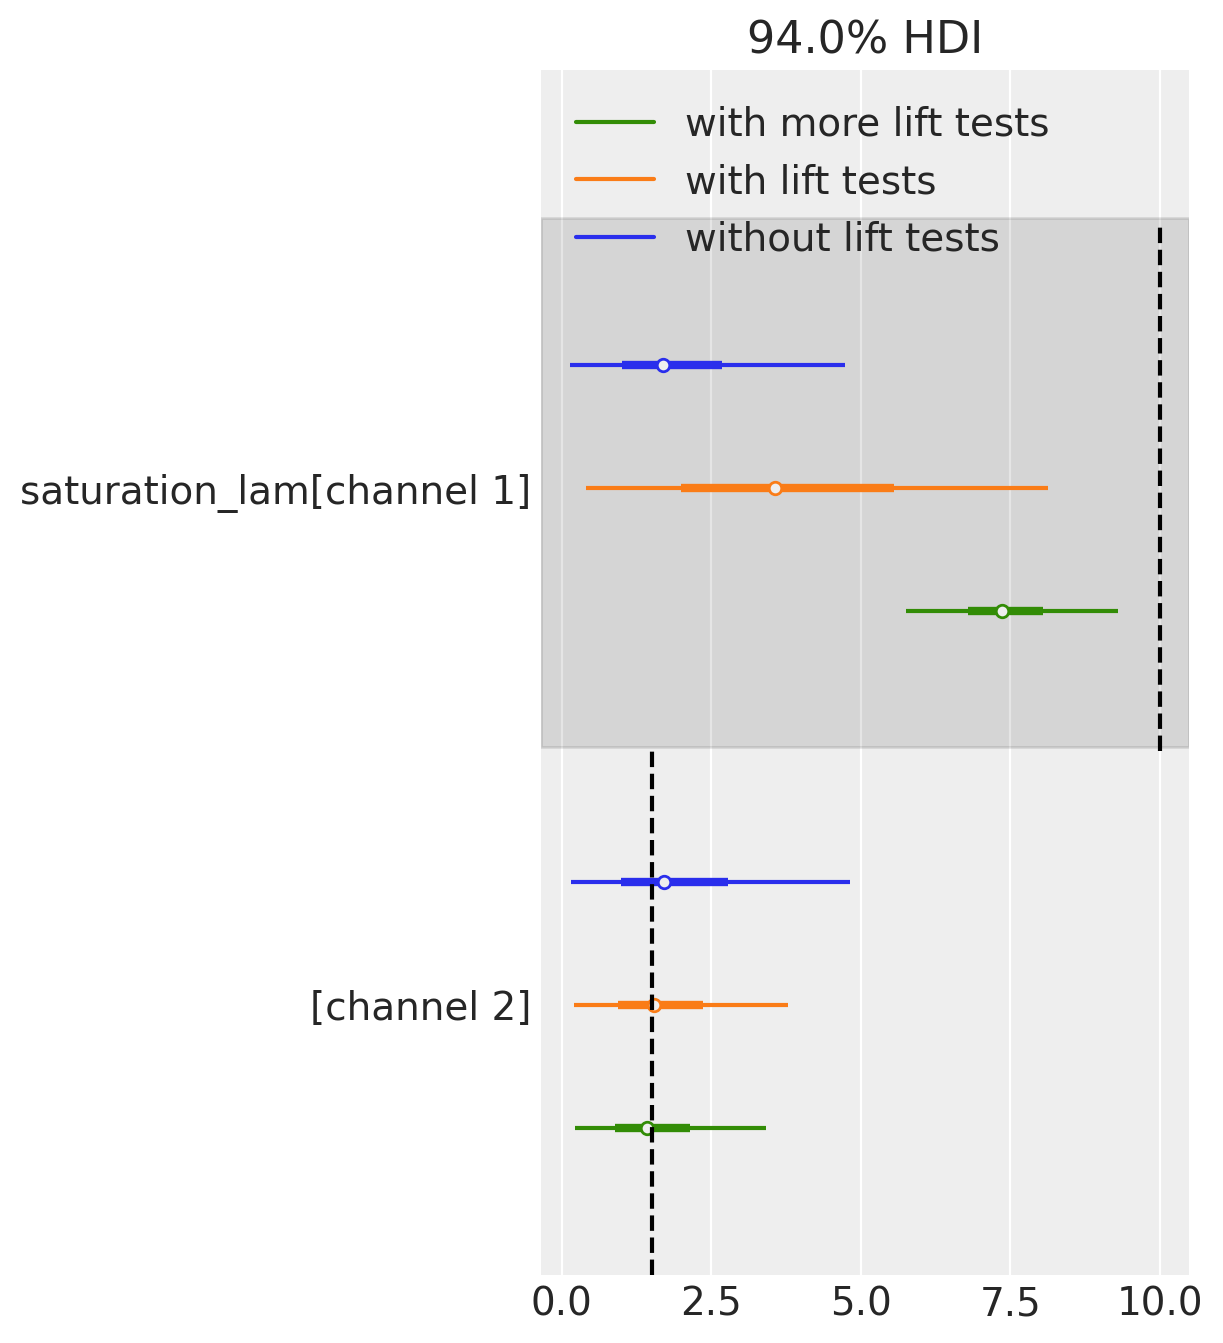

In [34]:
data = [idata_without, idata_with, idata_with_more]
model_names = ["without lift tests", "with lift tests", "with more lift tests"]

ax = plot_comparison(data, model_names, "saturation_lam")
plot_true_value(true_lam_c1, "channel 1", ax, split=0.435)
plot_true_value(true_lam_c2, "channel 2", ax, split=0.435);

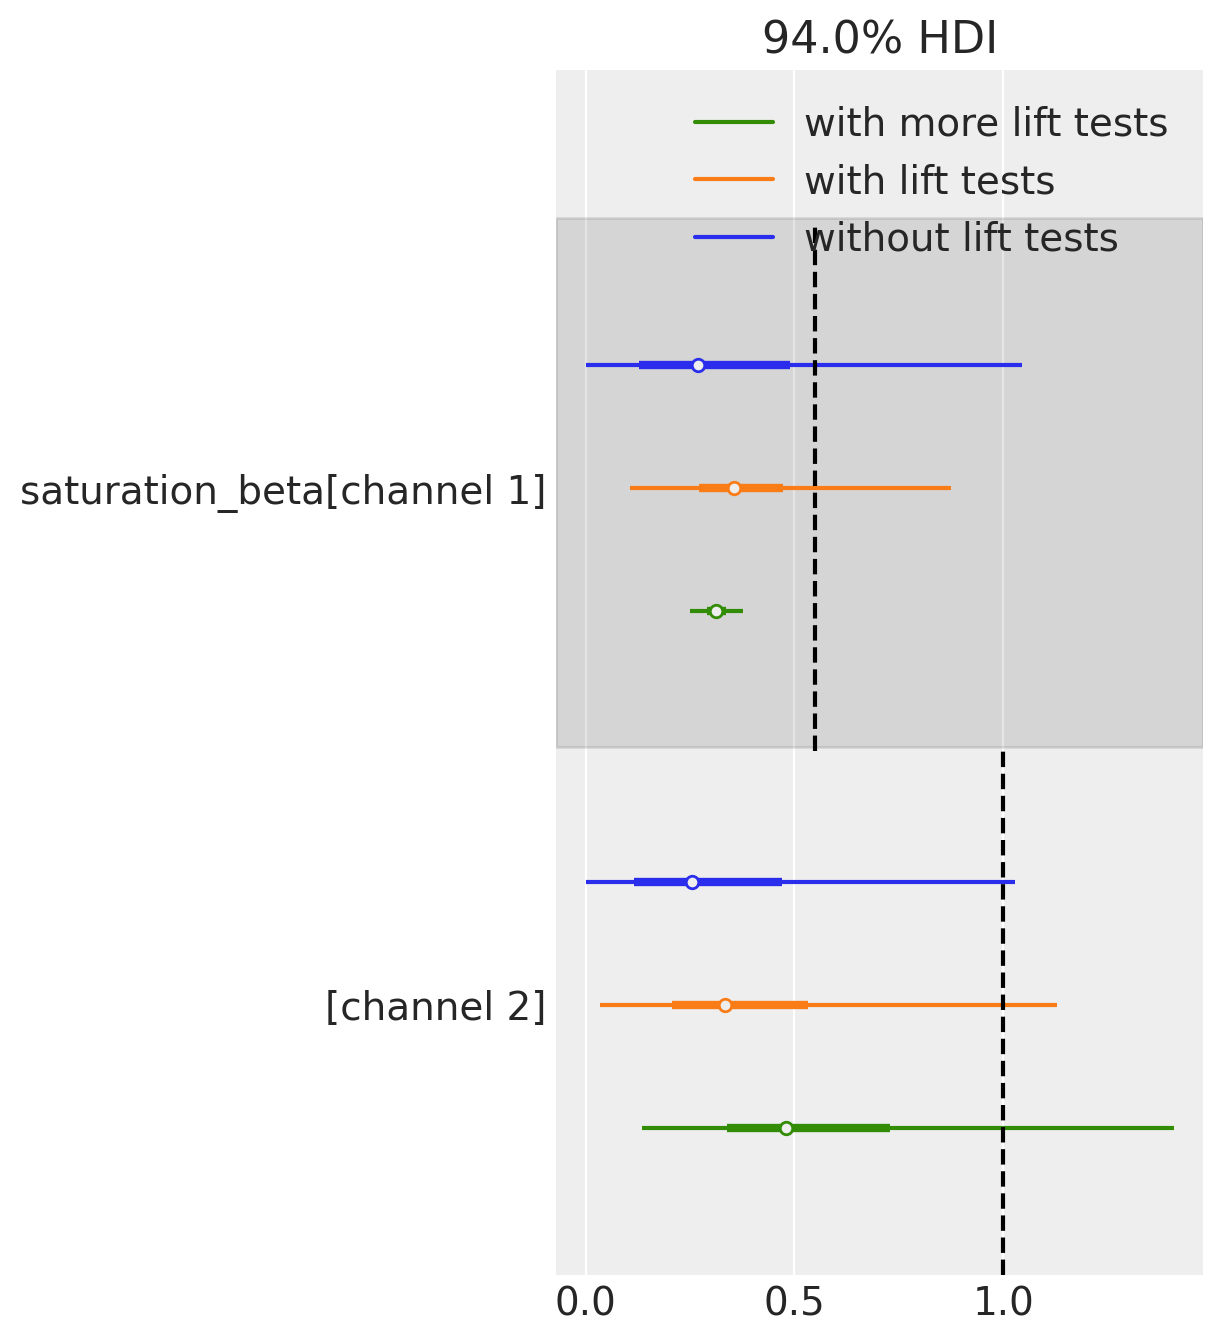

In [35]:
ax = plot_comparison(data, model_names, "saturation_beta")
plot_true_value(true_beta_c1, "channel 1", ax, split=0.435)
plot_true_value(true_beta_c2, "channel 2", ax, split=0.435);

## Conclusion

The `add_lift_test_measurements` method can be used in order to incorporate experiments into our model likelihood and nudge the model parameters closer to the actuals in this example.

Conducting various experiments for each channel at various spends will bring the best results.

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing -p pytensor

Last updated: Wed Sep 04 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

pytensor: 2.22.1

matplotlib: 3.8.4
arviz     : 0.18.0
pandas    : 2.2.2
numpy     : 1.26.4
pymc      : 5.15.1

Watermark: 2.4.3

